In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import re

from wordcloud import WordCloud

import nltk
stop_words = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from datetime import datetime

In [2]:
# initialize the empty dataframe
df = pd.DataFrame(columns=['URL', 'Heading', 'SubHeadings', 'Content'])

In [3]:
def get_links_from_bbc_news():
    res = requests.get('https://www.bbc.com/news')

    # Check if the request was successful
    if res.status_code == 200:
        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        top_stories_div = soup_data.find('div', class_='nw-c-top-stories--international')

        if top_stories_div:

            promo_headings = top_stories_div.find_all('a', class_=lambda x: x and 'gs-c-promo-heading' in x)

            links = [heading['href'] for heading in promo_headings]

            return links
        else:
            print("The 'nw-c-top-stories--international' div was not found on the page.")
    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [4]:
links = get_links_from_bbc_news()
len(links)

15

In [5]:
# drop duplicates
links = list(set(links))
links = [link for link in links if 'live' not in link and 'https' not in link]
links

['/news/world-australia-67712369',
 '/sport/cricket/67712627',
 '/news/world-asia-67712367',
 '/news/world-67710141',
 '/news/world-us-canada-67710761',
 '/news/science-environment-67694164',
 '/news/world-middle-east-67701700',
 '/news/business-67712101',
 '/news/world-australia-67700410',
 '/news/uk-england-norfolk-67711199',
 '/news/world-us-canada-67706835',
 '/news/world-us-canada-67712059',
 '/news/uk-67707647']

In [6]:
# assign the links to the dataframe
df['URL'] = links
df

,URL,Heading,SubHeadings,Content
0,/news/world-australia-67712369,NaN,NaN,NaN
1,/sport/cricket/67712627,NaN,NaN,NaN
2,/news/world-asia-67712367,NaN,NaN,NaN
3,/news/world-67710141,NaN,NaN,NaN
4,/news/world-us-canada-67710761,NaN,NaN,NaN
5,/news/science-environment-67694164,NaN,NaN,NaN
6,/news/world-middle-east-67701700,NaN,NaN,NaN
7,/news/business-67712101,NaN,NaN,NaN
8,/news/world-australia-67700410,NaN,NaN,NaN
9,/news/uk-england-norfolk-67711199,NaN,NaN,NaN


In [7]:
MAIN_URL = 'https://www.bbc.com'

In [8]:
def requestArticle(idx, url):
    url_to_fetch = MAIN_URL + url

    # Send an HTTP GET request to the specified URL
    res = requests.get(url_to_fetch)

    # Check if the request was successful
    if res.status_code == 200:
        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        meta = soup_data.find('meta', attrs={'property': 'article:section'})

        if meta:
            # print("Topic:", meta['content'])
            df.loc[idx, 'Topic'] = meta['content']

        # Find the <article> tag and get all elements inside it
        article = soup_data.find('article')

        if article:
            # Find all elements (tags) inside the <article> tag
            article_elements = article.find_all()
            
            # Extract the heading
            heading = article.find('h1').text
            # print("Heading")
            # print(heading)

            # Extract the subheadings
            # get headlines with data-component="subheadline-block"
            subheadings = article.find_all('div', attrs={'data-component': 'subheadline-block'})
            subheadings = [subheading for subheading in subheadings if 'You may also be interested in:' not in subheading.text]
            subheadings = [subheading.text for subheading in subheadings]
            subheadings = (', ').join(subheadings)
            # print("SubHeading")
            # print(subheadings)


            # Extract the content
            content = '\n'.join([element.text for element in article_elements if element.name == 'p'])
            # print("Content")
            # print(content)

            # Update the dataframe
            df.loc[idx, 'Heading'] = heading
            df.loc[idx, 'SubHeadings'] = subheadings
            df.loc[idx, 'Content'] = content
            df.loc[idx, 'RequestDate'] = pd.Timestamp.now()
            

        else:
            print("No <article> tag found on the page.")

    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [9]:
# Loop through the links and request each article
for idx, link in enumerate(links):
    requestArticle(idx, link)

In [10]:
def cleanText(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens] # everything lowercase
    tokens = [word.strip() for word in tokens] # strips whitespaces
    tokens = [word for word in tokens if word.isalnum()] # only alpha numerical values
    tokens = [word for word in tokens if not word in stop_words] # removes stopwords
    return tokens 

In [11]:
df.fillna('', inplace=True)
df['Cleaned_Heading'] = df['Heading'].apply(cleanText)
df['Cleaned_SubHeadings'] = df['SubHeadings'].apply(cleanText)
df['Cleaned_Content'] = df['Content'].apply(cleanText)


In [12]:
df

,URL,Heading,SubHeadings,Content,Topic,RequestDate,Cleaned_Heading,Cleaned_SubHeadings,Cleaned_Content
0,/news/world-australia-67712369,Australian woman charged with stealing van car...,,A woman in Australia has been charged with ste...,Australia,2023-12-14 10:42:13.450413,"[australian, woman, charged, stealing, van, ca...",[],"[woman, australia, charged, stealing, delivery..."
1,/sport/cricket/67712627,Cameron Green: Australia all-rounder suffering...,,Last updated on 12 minutes ago12 minutes ago.F...,,2023-12-14 10:42:13.798871,"[cameron, green, australia, suffering, chronic...",[],"[last, updated, 12, minutes, ago12, minutes, s..."
2,/news/world-asia-67712367,Japan: Four cabinet ministers quit over fundra...,,Four cabinet ministers in Japan quit on Thursd...,Asia,2023-12-14 10:42:14.023321,"[japan, four, cabinet, ministers, quit, fundra...",[],"[four, cabinet, ministers, japan, quit, thursd..."
3,/news/world-67710141,Moment elephant smashes van window in search o...,,This video can not be played\nThis is the mome...,,2023-12-14 10:42:14.174758,"[moment, elephant, smashes, van, window, searc...",[],"[video, played, moment, family, left, shock, e..."
4,/news/world-us-canada-67710761,US House votes to authorise Biden impeachment ...,,The US House of Representatives has voted to f...,US & Canada,2023-12-14 10:42:14.266655,"[us, house, votes, authorise, biden, impeachme...",[],"[us, house, representatives, voted, formalise,..."
5,/news/science-environment-67694164,A23a: Monster iceberg just shy of a trillion t...,,Scientists now have good numbers to describe t...,Science & Environment,2023-12-14 10:42:14.355509,"[a23a, monster, iceberg, shy, trillion, tonnes]",[],"[scientists, good, numbers, describe, true, sc..."
6,/news/world-middle-east-67701700,Israel-Gaza war: What is the price of peace?,"The widow of Muhammad Abu Shaar, Yonatan Zeige...",Just getting to the end of the day and survivi...,Middle East,2023-12-14 10:42:14.454105,"[war, price, peace]","[widow, muhammad, abu, shaar, yonatan, zeigen,...","[getting, end, day, surviving, night, must, fe..."
7,/news/business-67712101,Etsy: Online marketplace lays off 11% of staff...,What is Etsy and who owns it?,"Etsy is cutting about 225 jobs, or 11% of its ...",Business,2023-12-14 10:42:14.539713,"[etsy, online, marketplace, lays, 11, staff, c...","[etsy, owns]","[etsy, cutting, 225, jobs, 11, workforce, part..."
8,/news/world-australia-67700410,Kathleen Folbigg: Woman jailed over infant dea...,,This video can not be played\nâThe system pr...,Australia,2023-12-14 10:42:14.624960,"[kathleen, folbigg, woman, jailed, infant, dea...",[],"[video, played, system, preferred, blame, kath..."
9,/news/uk-england-norfolk-67711199,Great Yarmouth circus show stopped after acrob...,,A circus performer has been taken to hospital ...,Norfolk,2023-12-14 10:42:14.869995,"[great, yarmouth, circus, show, stopped, acrob...",[],"[circus, performer, taken, hospital, falling, ..."


In [14]:
# join all the tokens into a single string
df['MergedText'] = df['Cleaned_Heading'] + df['Cleaned_SubHeadings'] + df['Cleaned_Content']
df['MergedText'] = df['MergedText'].apply(lambda x: ' '.join(x))

df

,URL,Heading,SubHeadings,Content,Topic,RequestDate,Cleaned_Heading,Cleaned_SubHeadings,Cleaned_Content,MergedText
0,/news/world-australia-67712369,Australian woman charged with stealing van car...,,A woman in Australia has been charged with ste...,Australia,2023-12-14 10:42:13.450413,"[australian, woman, charged, stealing, van, ca...",[],"[woman, australia, charged, stealing, delivery...",australian woman charged stealing van carrying...
1,/sport/cricket/67712627,Cameron Green: Australia all-rounder suffering...,,Last updated on 12 minutes ago12 minutes ago.F...,,2023-12-14 10:42:13.798871,"[cameron, green, australia, suffering, chronic...",[],"[last, updated, 12, minutes, ago12, minutes, s...",cameron green australia suffering chronic kidn...
2,/news/world-asia-67712367,Japan: Four cabinet ministers quit over fundra...,,Four cabinet ministers in Japan quit on Thursd...,Asia,2023-12-14 10:42:14.023321,"[japan, four, cabinet, ministers, quit, fundra...",[],"[four, cabinet, ministers, japan, quit, thursd...",japan four cabinet ministers quit fundraising ...
3,/news/world-67710141,Moment elephant smashes van window in search o...,,This video can not be played\nThis is the mome...,,2023-12-14 10:42:14.174758,"[moment, elephant, smashes, van, window, searc...",[],"[video, played, moment, family, left, shock, e...",moment elephant smashes van window search food...
4,/news/world-us-canada-67710761,US House votes to authorise Biden impeachment ...,,The US House of Representatives has voted to f...,US & Canada,2023-12-14 10:42:14.266655,"[us, house, votes, authorise, biden, impeachme...",[],"[us, house, representatives, voted, formalise,...",us house votes authorise biden impeachment inq...
5,/news/science-environment-67694164,A23a: Monster iceberg just shy of a trillion t...,,Scientists now have good numbers to describe t...,Science & Environment,2023-12-14 10:42:14.355509,"[a23a, monster, iceberg, shy, trillion, tonnes]",[],"[scientists, good, numbers, describe, true, sc...",a23a monster iceberg shy trillion tonnes scien...
6,/news/world-middle-east-67701700,Israel-Gaza war: What is the price of peace?,"The widow of Muhammad Abu Shaar, Yonatan Zeige...",Just getting to the end of the day and survivi...,Middle East,2023-12-14 10:42:14.454105,"[war, price, peace]","[widow, muhammad, abu, shaar, yonatan, zeigen,...","[getting, end, day, surviving, night, must, fe...",war price peace widow muhammad abu shaar yonat...
7,/news/business-67712101,Etsy: Online marketplace lays off 11% of staff...,What is Etsy and who owns it?,"Etsy is cutting about 225 jobs, or 11% of its ...",Business,2023-12-14 10:42:14.539713,"[etsy, online, marketplace, lays, 11, staff, c...","[etsy, owns]","[etsy, cutting, 225, jobs, 11, workforce, part...",etsy online marketplace lays 11 staff cut cost...
8,/news/world-australia-67700410,Kathleen Folbigg: Woman jailed over infant dea...,,This video can not be played\nâThe system pr...,Australia,2023-12-14 10:42:14.624960,"[kathleen, folbigg, woman, jailed, infant, dea...",[],"[video, played, system, preferred, blame, kath...",kathleen folbigg woman jailed infant deaths co...
9,/news/uk-england-norfolk-67711199,Great Yarmouth circus show stopped after acrob...,,A circus performer has been taken to hospital ...,Norfolk,2023-12-14 10:42:14.869995,"[great, yarmouth, circus, show, stopped, acrob...",[],"[circus, performer, taken, hospital, falling, ...",great yarmouth circus show stopped acrobat fal...


In [15]:
def TfIdfvectorGenerator(documents_preprocessed):
    """ Taking a corpus of documents which have been preprocessed and exist in string shape, 
    creates TFIDF representations and returns the representations, and the TFIDF vectorizer"""
    from datetime import datetime
    beg = datetime.now()
    vectorizer = TfidfVectorizer(min_df=1,
                                 max_df=0.75) 
    
    tfidf = vectorizer.fit_transform(documents_preprocessed)  #note that you must use the preprocessed documents in string 
                                                                #form for this function/method
    end = datetime.now()
    
    print('documents processed:',tfidf.shape[0])
    print('time spent:',end-beg)
    return tfidf, vectorizer

In [16]:
tfidf, vectorizer = TfIdfvectorGenerator(df['MergedText']) 

documents processed: 13
time spent: 0:00:00.008353


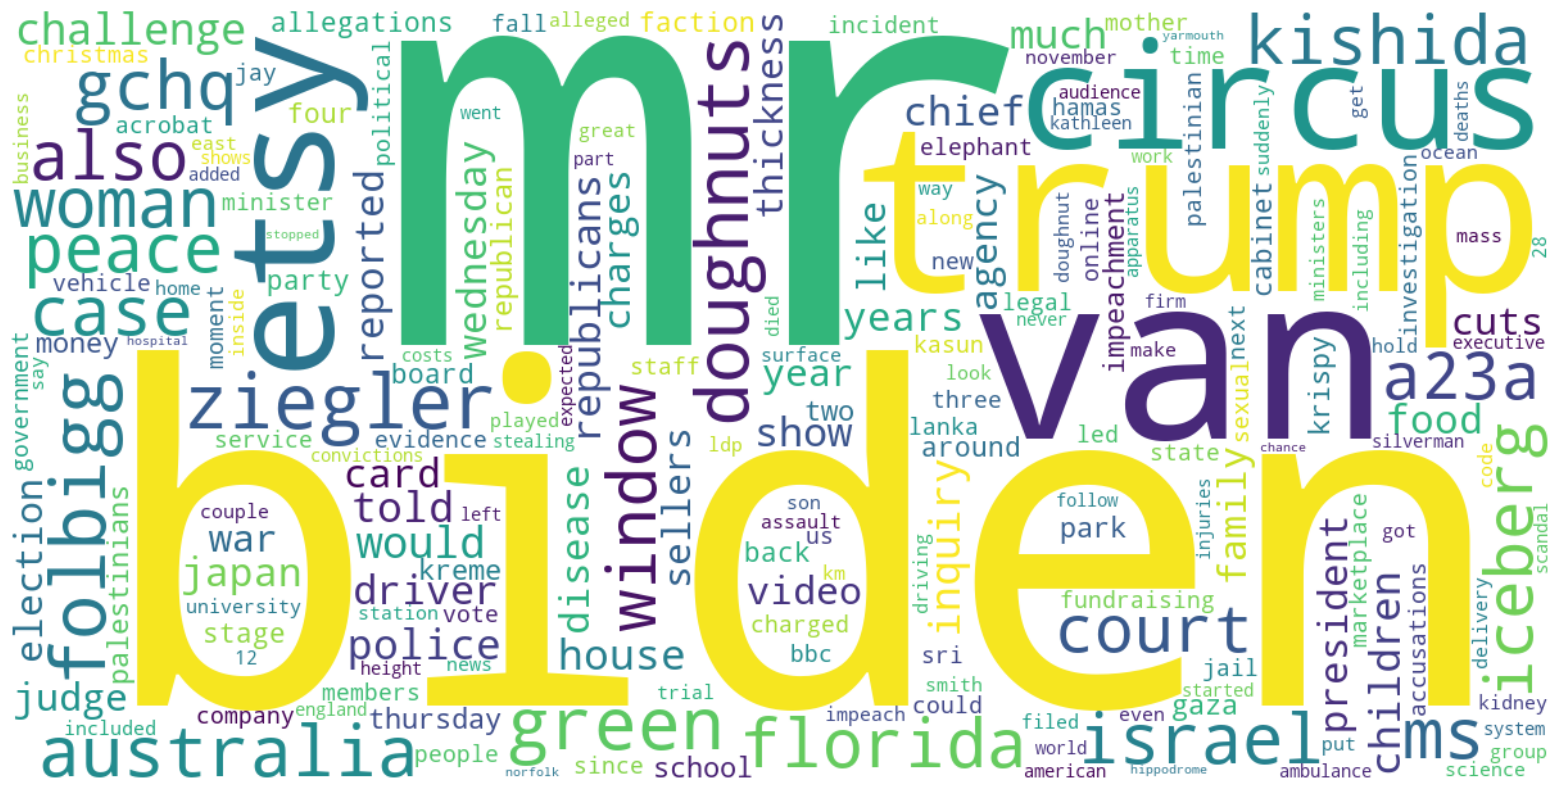

In [17]:
# Step 2: Rank words by TF-IDF scores
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each word
tfidf_scores = tfidf.sum(axis=0).A1

# Create a dictionary of words and their TF-IDF scores
word_scores = dict(zip(feature_names, tfidf_scores))

# Step 3: Generate a word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white')
wordcloud.generate_from_frequencies(word_scores)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.show()
todayDate = datetime.today().strftime('%Y-%m-%d-%H%M%S')
plt.savefig('clouds/' + todayDate + '_wordcloud.png', dpi=300)

In [ ]:
import smtplib
import os
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from dotenv import load_dotenv

load_dotenv()

# create message object instance
msg = MIMEMultipart()

# setup the parameters of the message
password = os.environ.get('MAIL_PASSWORD')
msg['From'] = os.environ.get('MAIL_FROM')
msg['To'] = os.environ.get('MAIL_TO')
msg['Subject'] = "Todays WordCloud to the top news of BBC"
msg['Body'] = "Todays WordCloud to the top news of BBC, see attached image"

# attach image to message body
fp = open('clouds/' + todayDate + '_wordcloud.png', 'rb')
img = MIMEImage(fp.read())
fp.close()
msg.attach(img)

# create server
server = smtplib.SMTP(os.environ.get('MAIL_HOST'))

server.starttls()

# Login Credentials for sending the mail
server.login(os.environ.get('MAIL_USER'), password)

# send the message via the server.
server.sendmail(msg['From'], msg['To'], msg.as_string())

server.quit()

print("successfully sent email to %s:" % (msg['To']))